In [ ]:
!pip -q install kaggle  

In [ ]:
# IMPORTS

import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import requests
import time
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
COLAB = os.path.exists('/content/')

if COLAB:
    BASE_DIR = '/content'
else:
    BASE_DIR = '.'

In [ ]:
# Download Flickr8K dataset

if not os.path.exists(f'{BASE_DIR}/data/'):
    
    # Enter your kaggle credentials
    api_token = {"username":"chollangiharshitha","key":"6dba24c7f6cbd1f7c7f5d124ca97d16b"}

    with open(f'{BASE_DIR}/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = BASE_DIR
    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs(f'{BASE_DIR}/data/', exist_ok=True)
    os.system(f'mv {BASE_DIR}/flickr8k.zip {BASE_DIR}/data/flickr8k.zip')
    os.system(f'unzip -q {BASE_DIR}/data/flickr8k.zip -d {BASE_DIR}/data/')
    os.remove(f'{BASE_DIR}/data/flickr8k.zip')

In [ ]:
# load the captions.txt with pandas
captions = pd.read_csv(f'{BASE_DIR}/data/captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
print('Dataset shape:', captions.shape)

Dataset shape: (40455, 2)


In [ ]:
# Because the image column only provides the picture name, let's input  the image's full path so we can quickly access it.

captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_DIR}/data/Images/{x}')

In [ ]:
#Text Processing
def preprocess(text):
    
    # making it lowercase
    text = text.lower()

    # remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # remove extra spaces
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    # add [start] and [end] special token
    text = '[start] ' + text + ' [end]'

    return text

In [ ]:
#use text pre-processing on the caption column
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a child in a pink dress is climbing up...
1,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a girl going into a wooden building [end]
2,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing into a wooden p...
3,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl climbing the stairs to h...
4,/content/data/Images/1000268201_693b08cb0e.jpg,[start] a little girl in a pink dress going in...


[start] a small black and white dog in a harness is looking at the camera [end]



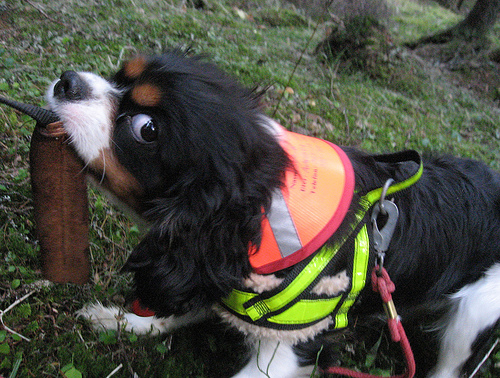

In [ ]:
# show a random image and caption
random_row = captions.sample(1).iloc[0]

# the caption of a random row
print(random_row.caption + '\n')

# display the image of a random row.
im = Image.open(random_row.image)
im

#You will get a new image each time you run this cell.

In [ ]:
# Load the Inception V3 model
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)
inception_v3.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
#image preprocessing
def load_image(path):

   #image loading
    img = tf.io.read_file(path)

     #tensorflow
    img = tf.io.decode_jpeg(img, channels=3)

    # resize 299 X 299
    img = tf.keras.layers.Resizing(299, 299)(img)

    #preprocess with inception v3
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, path

In [ ]:
#  8000 distinct image pathways were drawn from the dataset.
unique_img_paths = sorted(list(captions['image'].unique()))

#We will use the TensorFlow Dataset to batch picture paths.
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_paths)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [ ]:
# Let's loop through all of the image paths, load them using our load_img() function, and then save them in the feature_vectors directory.

fv_path = f'{BASE_DIR}/feature_vectors/'
os.makedirs(fv_path, exist_ok=True)

for img, paths in tqdm(image_dataset, total=len(image_dataset)):
    feature_vector = inception_v3(img)
    # the feature_vector shape (batch_size, 8, 8, 2048)
    
    feature_vector = tf.reshape(
        feature_vector,
        (feature_vector.shape[0], -1, feature_vector.shape[3])
    )
    # It now has the following shape: batch_size, 8*8, 2048 = (batch_size, 64, 2048).
    for fv, path in zip(feature_vector, paths):
        path = path.numpy().decode("utf-8")
        path = fv_path + path.split('/')[-1]
        np.save(path, fv.numpy())

  0%|          | 0/506 [00:00<?, ?it/s]

In [ ]:
# Add the feature_vector column, which will include the path to the feature vector for each image.

captions['feature_vector'] = captions['image'].apply(
    lambda x: x.replace('data/Images', 'feature_vectors') + '.npy'
)

captions = captions[['image', 'feature_vector', 'caption']]
captions.head()

In [ ]:
# caption text vectorization

max_length = 40 # maximum word count for a sentence
vocabulary_size = 5000   # largest possible vocabulary

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    output_sequence_length=max_length)

# The adapt feature will increase vocabulary.
tokenizer.adapt(captions['caption'])

In [ ]:
#Test the "tokenizer" now.
tokenizer(['a dog running'])

In [ ]:
import pickle
pickle.dump(tokenizer.get_vocabulary(), open('vocab_encdec.file', 'wb'))

In [ ]:
# developing word2idx and idx2word in order to quickly convert words to indexes and vice versa.

word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
#FV stands for feature vectors in the train and test validation split 
fv_to_cap_vector = collections.defaultdict(list)
for fv, cap in zip(captions['feature_vector'], captions['caption']):
    fv_to_cap_vector[fv].append(cap)

fv_keys = list(fv_to_cap_vector.keys())
random.shuffle(fv_keys)

slice_index = int(len(fv_keys)*0.8)
fv_name_train_keys, fv_name_val_keys = fv_keys[:slice_index], fv_keys[slice_index:]

train_feature_vectors = []
train_captions = []
for fvt in fv_name_train_keys:
    capt_len = len(fv_to_cap_vector[fvt])
    train_feature_vectors.extend([fvt] * capt_len)
    train_captions.extend(fv_to_cap_vector[fvt])

val_feature_vectors = []
val_captions = []
for fvv in fv_name_val_keys:
    capv_len = len(fv_to_cap_vector[fvv])
    val_feature_vectors.extend([fvv] * capv_len)
    val_captions.extend(fv_to_cap_vector[fvv])

In [ ]:
print(len(train_feature_vectors), len(val_feature_vectors))

In [ ]:
# Examining the layout of railroad images and captions
print(train_feature_vectors[0])
print()
print(train_captions[0])

In [ ]:
#Putting image and captions together

In [ ]:
#combining a picture and a caption Hyper-Parameters

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = tokenizer.vocabulary_size()

In [ ]:
#This image will load a feature vector array, receive a feature vector path and a caption string, tokenize the caption before returning it, and then load a feature vector array.

def load_data(fv_path, caption):
  

    # Step 1: Load feature vector
    feature_vector = np.load(fv_path.decode('utf-8'))

    # Step 2: Tokenize caption
    tokenized_caption = tokenizer(caption)

    return feature_vector, tokenized_caption

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_feature_vectors, train_captions))


# load_data()
train_dataset = train_dataset.map(
    lambda item1, item2: tf.numpy_function(
        load_data, [item1, item2], [tf.float32, tf.int64]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

# shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


# Repeat for the validation set.
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_feature_vectors, val_captions))

val_dataset = val_dataset.map(
    lambda item1, item2: tf.numpy_function(
        load_data, [item1, item2], [tf.float32, tf.int64]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
img, cap = next(iter(train_dataset))
print('Image shape:', img.shape)
print('Caption shape:', cap.shape)

In [ ]:
# Its Encoder We have already saved all of the feature vectors, so we can send them all via a completely linked layer. After this change, it will have the shape (batch_size, 64, embedding_dim). There won't be any learning taking place at the encoder component if you skip this layer.

class CNNEncoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
# The Attention mechanisn

class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, features, hidden):
        # I have explained this here:
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) +
                                  self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
# The Decoder

class RNNDecoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, units, vocab_size):
        super(RNNDecoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
        )
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
               # We will compute the attention between the hidden state of the text and the feature vector of the image.
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights


    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNNEncoder(embedding_dim)
decoder = RNNDecoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

def loss_fn(y_true, y_pred):
    # calculate loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)


    # We are going to hide the padding tokens.
    mask = y_true != 0
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [ ]:
loss_history = []

In [ ]:
 #a forward and backward pass of one batch, initial loss is zero, loss equals 0.

    #Since the captions are unrelated from image to image, initializing the concealed state for each batch

@tf.function
def train_step(img_tensor, target):
   
    # initial decoder input
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # initial decoder input
    dec_input = tf.expand_dims(target[:, 0], 1)

    with tf.GradientTape() as tape:
        # getting features from encoder
        features = encoder(img_tensor)

        # we will generate the next words with this for loop
        for i in range(1, target.shape[1]):
            # pass features and captions through decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # calculate loss between the predicted next word and the actual next word
            loss += loss_fn(target[:, i], predictions)

            # teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    # taking the mean of total_loss
    total_loss = (loss / int(target.shape[1]))

    # backward pass
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 2

# The training loop

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    with tqdm(total=len(train_dataset)) as pbar:

        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            # run the `train_step()` for every batch
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            # we will pring loss value after every 100 batch
            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
            pbar.update(1)
    
    loss_history.append(total_loss/len(train_dataset))

    print(f'Epoch {epoch+1} Loss {total_loss/len(train_dataset):.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
plt.plot(loss_history)
plt.title('Loss curve')
plt.show()

In [ ]:
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_v3(temp_input)

    img_tensor_val = tf.reshape(
        img_tensor_val, 
        (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word2idx('[start]')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(idx2word(predicted_id).numpy())

        if predicted_word == '[end]':
            return result
            
        result.append(predicted_word)

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
random_row = captions.sample(1).iloc[0]

image = random_row['image']
caption = random_row['caption'] 

result = evaluate(image)

print('Real Caption:', caption)
print('\nPrediction Caption:', ' '.join(result))
print()
Image.open(image)